# Multiclass Support Vector Machine exercise
(Adapted from Stanford University's CS231n Open Courseware)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir, num_of_batches=6)
# Increase num_of_batches to 6 if you have sufficient memory

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


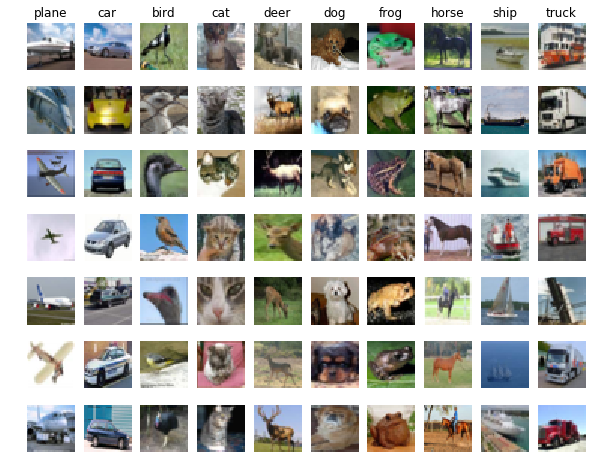

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
#Increase this if you have memory: num_training = 49000
num_validation = 1000
num_test = 1000

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


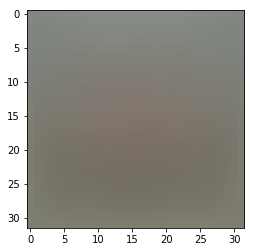

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print (mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

print (X_train.shape, X_val.shape, X_test.shape)

(3073, 49000) (3073, 1000) (3073, 1000)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
# num_classes = 10 X_train.shape[0] sample size
sample_size = X_train.shape[0]
W = np.random.randn(num_classes, sample_size) * 0.0001 
loss, grad = svm_loss_naive(W, X_train, y_train, 0.00001)
print ('loss: %f' % (loss, ))

loss: 8.738655


In [10]:
#print(grad.shape)
#print(grad[:,1].shape)
#print(grad[:,1])

#print(y_train)

(10, 3073)
(10,)
[-26.82049754  -4.89052241   5.29863647  17.82402936  22.63252539
  28.44001472  20.15248886  -2.031725   -26.64325478 -33.96169507]
[6 9 9 ..., 4 9 3]


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_train, y_train, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 22.073980 analytic: 22.075801, relative error: 4.124393e-05
numerical: -4.294087 analytic: -4.295391, relative error: 1.518949e-04
numerical: 11.647187 analytic: 11.647608, relative error: 1.804501e-05
numerical: 0.619803 analytic: 0.621537, relative error: 1.396683e-03
numerical: -1.531969 analytic: -1.532975, relative error: 3.281881e-04
numerical: 3.353785 analytic: 3.351698, relative error: 3.112293e-04
numerical: -22.793632 analytic: -22.793765, relative error: 2.908700e-06
numerical: -2.164618 analytic: -2.168453, relative error: 8.850412e-04
numerical: -2.700979 analytic: -2.701349, relative error: 6.855118e-05
numerical: -11.972493 analytic: -11.971645, relative error: 3.541104e-05


**Inline Question 1:**
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
naive_time = toc - tic
print('Naive loss: %e computed in %fs' % (loss_naive, naive_time))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
vec_time = toc - tic
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, vec_time))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))
print('Time difference: ', naive_time / vec_time)

Naive loss: 8.738655e+00 computed in 14.320590s
Vectorized loss: 8.738655e+00 computed in 1.246712s
difference: -0.000000
Time difference:  11.486686495487072


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
naive_time = toc - tic
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
vec_time = toc - tic
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)
print('Time difference: ', naive_time / vec_time)

Naive loss and gradient: computed in 12.922345s
Vectorized loss and gradient: computed in 1.270790s
difference: 0.000000
Time difference:  10.168746403666285


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [14]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, 
                      reg=5e4, num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 792.240207
iteration 100 / 1500: loss 289.340645
iteration 200 / 1500: loss 109.023356
iteration 300 / 1500: loss 42.906930
iteration 400 / 1500: loss 18.792967
iteration 500 / 1500: loss 9.992378
iteration 600 / 1500: loss 6.809818
iteration 700 / 1500: loss 5.833317
iteration 800 / 1500: loss 5.346486
iteration 900 / 1500: loss 5.346930
iteration 1000 / 1500: loss 5.207824
iteration 1100 / 1500: loss 5.764957
iteration 1200 / 1500: loss 5.778433
iteration 1300 / 1500: loss 5.631393
iteration 1400 / 1500: loss 5.263905
That took 11.356932s


Text(0,0.5,'Loss value')

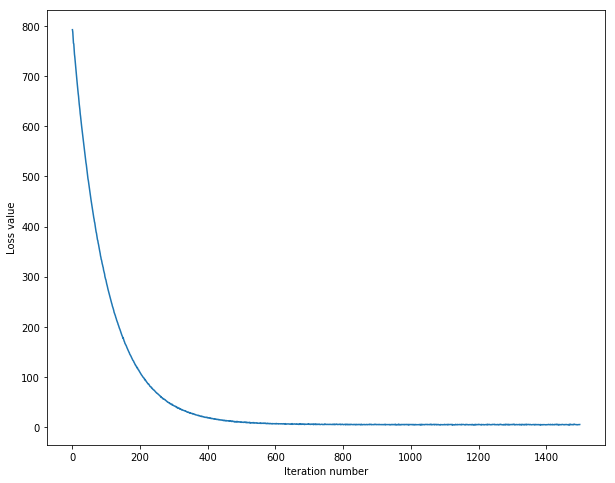

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369837
validation accuracy: 0.379000


In [ ]:
# over flow
# lr:  5e-05  reg:  50000.0
# lr:  5e-05  reg:  50000.0
# lr:  1e-06  reg:  10000000.0

In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = []#[1e-8, 1e-7, 1e-6] #[1e-7, 5e-5]
regularization_strengths = []#[1e3, 1e4, 1e5] #[5e4, 1e5]


# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for i in range(3):
    lr = 10 ** np.random.uniform(-7.5, -6.5) #(-8, -6)
    reg = 10 ** np.random.uniform(4, 5) #(3, 6)
    learning_rates.append(lr)
    regularization_strengths.append(reg)

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, 
                      reg=reg, num_iters=1500, verbose=False)
        
        
        # accurecies
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        
        
        if (best_val < val_acc or best_val == -1):
            best_val = val_acc
            best_svm = svm
        
        print('lr: ', lr, ' reg: ', reg, ' loss: ', loss_hist[-1], ' acc: ', train_acc, ' val_acc: ', val_acc)
        
        results[(lr, reg)] = (train_acc, val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results ):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

lr:  5.427034405043996e-08  reg:  69385.02253755291  loss:  4.99023278188  acc:  0.365632653061  val_acc:  0.377
lr:  5.427034405043996e-08  reg:  21332.31309071104  loss:  14.6873210289  acc:  0.365612244898  val_acc:  0.359
lr:  5.427034405043996e-08  reg:  38780.431640542025  loss:  6.6441614135  acc:  0.375530612245  val_acc:  0.385
lr:  4.210746039455759e-08  reg:  69385.02253755291  loss:  5.9309241258  acc:  0.367408163265  val_acc:  0.39
lr:  4.210746039455759e-08  reg:  21332.31309071104  loss:  26.5480995537  acc:  0.346346938776  val_acc:  0.359
lr:  4.210746039455759e-08  reg:  38780.431640542025  loss:  9.34270345504  acc:  0.375326530612  val_acc:  0.391
lr:  8.982618987267201e-08  reg:  69385.02253755291  loss:  5.07316380875  acc:  0.359979591837  val_acc:  0.375
lr:  8.982618987267201e-08  reg:  21332.31309071104  loss:  5.97081274911  acc:  0.38506122449  val_acc:  0.398
lr:  8.982618987267201e-08  reg:  38780.431640542025  loss:  5.59813397093  acc:  0.375755102041  

- good results
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.303500 val accuracy: 0.316000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.384889 val accuracy: 0.361000 # best in set
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.361056 val accuracy: 0.360000
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.399333 val accuracy: 0.355000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.319667 val accuracy: 0.297000
- good results
lr 7.760013e-07 reg 2.575514e+03 train accuracy: 0.397556 val accuracy: 0.376000
lr 1.871471e-07 reg 2.755857e+04 train accuracy: 0.383278 val accuracy: 0.374000
lr 1.989885e-07 reg 6.477260e+04 train accuracy: 0.367167 val accuracy: 0.378000
lr 1.989885e-07 reg 2.755857e+04 train accuracy: 0.379667 val accuracy: 0.368000
lr 1.871471e-07 reg 2.755857e+04 train accuracy: 0.383278 val accuracy: 0.374000
lr 7.858351e-08 reg 2.755857e+04 train accuracy: 0.379167 val accuracy: 0.376000
lr 7.858351e-08 reg 4.716946e+04 train accuracy: 0.373889 val accuracy: 0.373000
lr 7.858351e-08 reg 6.477260e+04 train accuracy: 0.377444 val accuracy: 0.383000
lr 6.349722e-08 reg 2.755857e+04 train accuracy: 0.383833 val accuracy: 0.384000 # best in set
lr 6.349722e-08 reg 4.716946e+04 train accuracy: 0.378944 val accuracy: 0.377000

lr 3.965665e-08 reg 3.703490e+04 train accuracy: 0.376056 val accuracy: 0.387000

Text(0.5,1,'CIFAR-10 validation accuracy')

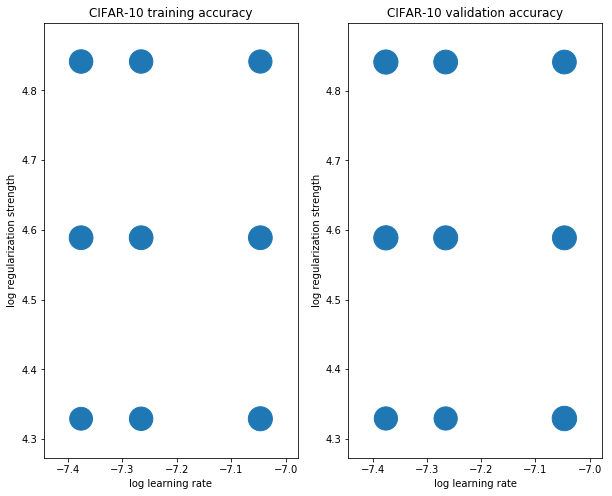

In [18]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
sz = [results[x][0]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,1)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
sz = [results[x][1]*1500 for x in results] # default size of markers is 20
plt.subplot(1,2,2)
plt.scatter(x_scatter, y_scatter, sz)
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

In [19]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.380000


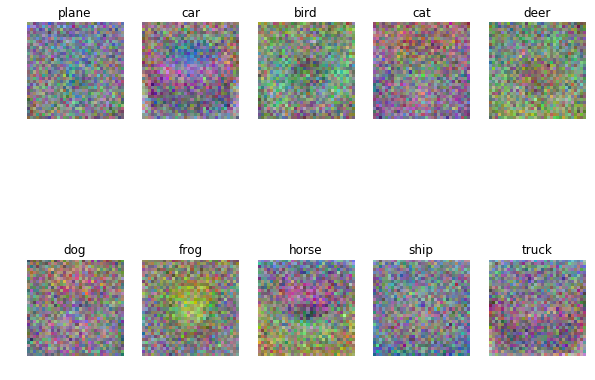

In [20]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *I can only distinguish car and frog weights. They has gethering in center of the weight matris that looks like kind of similarity like green center for frog and red center for car but also that looks like front of a car. It seems that similar fotos used in training set for frog and car because we cannot say all cars are red and not all frogs has vivid greed color. 
The other matrises seems like random noise.*